In [1]:
import os

network_path = os.path.join("networks", "slice_example")
mesh_file = os.path.join(network_path, "mesh", "slice.obj")

if not os.path.exists(os.path.dirname(mesh_file)):
    os.makedirs(os.path.dirname(mesh_file))
    

Create a custom slice that is 1000x1000x25 micrometers in size.

In [2]:
from snudda.create_slice_mesh import create_slice_mesh
create_slice_mesh(file_name=mesh_file,
                  centre_point=[0.0, 0.0, 0.0],
                  x_len=1e-3,
                  y_len=1e-3,
                  z_len=25e-6,
                  description="This is a test slice for Alex")

Creating slice mesh
File: networks/slice_example/mesh/slice.obj
Centre: [0. 0. 0.]
Sides: 0.001 x 0.001 x 2.5e-05
Description: This is a test slice for Alex


Here we populate the slice with dSPN and iSPN neurons.

First we ```define_structure```, specifying ```struct_name``` and the ```struct_mesh``` which is a [wavefront obj file](https://en.wikipedia.org/wiki/Wavefront_.obj_file). The ```d_min``` parameter (SI units, so meters) specify how close neurons can be placed. The ```mesh_bin_width``` is voxelisation of the mesh, and it needs to be larger than 2*```d_min```.

Next we ```add_neurons```, passing ```name``` of the neuron, ```volume_id``` it belongs to, and the ```neuron_dir``` where the neurons are located. Note that each dSPN neuron morphology has its own folder, so point to the parent folder e.g. data/neurons/dspn.

The next step is ```add_neuron_target``` which specifies how neurons are coupled together. The connection is from ```neuron_name``` to ```target_name``` of type ```connection_type``` (here GABA). 

The ```dist_pruning``` is optional, and allows us to form preferentially proximal or distal synapses. In this example ```"1-np.exp(-(0.4*d/60e-6)**2)"``` will result in distal synapses (```d``` is the dendritic distance from the soma). We also specify the pruning parameters ```f1``` (probability of keeping a synapse), ```soft_max``` (a soft upper limit on the number of synapses between connected pairs), ```mu2``` (a soft lower limit on the number of synapses between connected pairs) and ```a3``` (fraction of all connected pairs that we keep, this is useful for changing connection probability without affecting the number of synapses between connected pairs).

The ```conductance``` has two values, the mean and standard deviation. The ```parameter_file``` specifies parameters for the synapse which is moddeled by ```mod_file```. You can also specify additional synapse parameters using the ```channel_param_dictionary```.

Finally we need to write the config file.

In [3]:
from snudda.init import SnuddaInit

cnc = SnuddaInit(network_path=network_path)

# d_min normally 15e-6, here set to 12e-6 because slice is only 25 micrometers, 2*d_min < mesh_bin_width
cnc.define_structure(struct_name="SliceExample", struct_mesh=mesh_file, d_min=12e-6, mesh_bin_width=25e-6)
cnc.add_neurons(name="dSPN", num_neurons=1000, volume_id="SliceExample",
                neuron_dir=os.path.join(cnc.data_path,"neurons","striatum","dspn"))
cnc.add_neurons(name="iSPN", num_neurons=1000, volume_id="SliceExample",
                neuron_dir=os.path.join(cnc.data_path,"neurons","striatum","ispn"))

SPN2SPNdistDepPruning = "1-np.exp(-(0.4*d/60e-6)**2)"

MSD1gGABA = [0.24e-9, 0.1e-9]
MSD2gGABA = [0.24e-9, 0.1e-9]

MSD1GABAfailRate = 0.7  # Taverna 2008, figure 2
MSD2GABAfailRate = 0.4  # Taverna 2008, 2mM

pfdSPNdSPN = os.path.join(cnc.data_path, "synapses", "striatum", "PlanertFitting-DD-tmgaba-fit.json")
pfdSPNiSPN = os.path.join(cnc.data_path, "synapses", "striatum", "PlanertFitting-DI-tmgaba-fit.json")
pfiSPNdSPN = os.path.join(cnc.data_path, "synapses", "striatum", "PlanertFitting-ID-tmgaba-fit.json")
pfiSPNiSPN = os.path.join(cnc.data_path, "synapses", "striatum", "PlanertFitting-II-tmgaba-fit.json")

cnc.add_neuron_target(neuron_name="dSPN",
                       target_name="dSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.38, soft_max=3, mu2=2.4,
                       a3=1.0,
                       conductance=MSD1gGABA,
                       parameter_file=pfdSPNdSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD1GABAfailRate})


cnc.add_neuron_target(neuron_name="dSPN",
                       target_name="iSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.20, soft_max=3, mu2=2.4,
                       a3=1.0,
                       conductance=MSD1gGABA,
                       parameter_file=pfdSPNiSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD1GABAfailRate})


cnc.add_neuron_target(neuron_name="iSPN",
                       target_name="dSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.3, soft_max=4, mu2=2.4,
                       a3=1.0,
                       conductance=MSD2gGABA,
                       parameter_file=pfiSPNdSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD2GABAfailRate})

cnc.add_neuron_target(neuron_name="iSPN",
                       target_name="iSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.55, soft_max=4, mu2=2.4,
                       a3=1.0,
                       conductance=MSD2gGABA,
                       parameter_file=pfiSPNiSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD2GABAfailRate})

cnc.write_json()

CreateConfig
Seeding with rand_seed=None
Random seed init to 1086998677
Random seed place to 2061497739
Random seed detect to 1722284221
Random seed prune to 335354304
Random seed input to 2523075772
Random seed simulate to 1778258170
No structDef defined, not writing JSON file in init
Adding neurons: dSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn
Writing networks/slice_example/network-config.json


In [4]:
from snudda.place import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.read_config()
sp.write_data()

Using hdf5 version: latest
Parsing configuration file networks/slice_example/network-config.json
Reading random see from config file: 2061497739
Using mesh_bin_width 2.5e-05
Found old cache file (networks/slice_example/mesh/slice.obj-25-cache.pickle), ignoring.
Running in serial
Voxel mask: 44x44x5
Processing x = 0
Processing x = 1
Processing x = 2
Processing x = 3
Processing x = 4
Processing x = 5
Processing x = 6
Processing x = 7
Processing x = 8
Processing x = 9
Processing x = 10
Processing x = 11
Processing x = 12
Processing x = 13
Processing x = 14
Processing x = 15
Processing x = 16
Processing x = 17
Processing x = 18
Processing x = 19
Processing x = 20
Processing x = 21
Processing x = 22
Processing x = 23
Processing x = 24
Processing x = 25
Processing x = 26
Processing x = 27
Processing x = 28
Processing x = 29
Processing x = 30
Processing x = 31
Processing x = 32
Processing x = 33
Processing x = 34
Processing x = 35
Processing x = 36
Processing x = 37
Processing x = 38
Processi

This plots the network, here we leave out axons and dendrites in the figure. Note that matplotlib will distort the axis in 3D plots, causing somas to not appear as spheres.

Loading networks/slice_example/network-neuron-positions.hdf5
No SlurmID set, using -1
Load done. 0.01786840899148956
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c10_D1-mWT-P270-20-v20190521/WT-P270-20-15ak-cor-cache.pickle
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn/str-ispn-e150908_c4_D2-m51-5-DE-v20190611/51-5-DE-cor-rep-ax-cache.pickle
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150602_c1_D1-mWT-0728MSN01-v20190508/WT-0728MSN01-cor-rep-ax-cache.pickle
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c6_D1-m21-6-DE-v20190503/21-6-DE-cor-rep-ax-cache.pickle
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c9_d1-mWT-1215MSN03-v20190521/WT-1215MSN03-cor-rep-ax2-cache.pickle
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn/str-ispn-e160118_c10_D2-m46-3-D

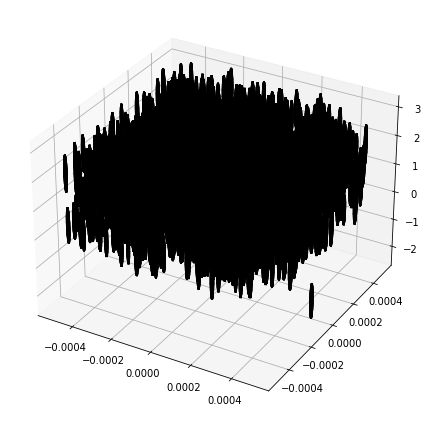

In [5]:
from snudda.plotting.plot_network import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

For completion, let us do detection and pruning also. Note that we have chosen to specify ```hyper_voxel_size``` in this example, default value is 100. Larger values will take more memory but should be a bit faster, especially if running in serial mode. If your computer runs out of memory, reduce the ```hyper_voxel_size```.

In [ ]:
from snudda.detect import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, hyper_voxel_size=250)
sd.detect()

Creating directory networks/slice_example/log
Using hdf5 driver version: latest
Memory: 62194225152 free, 67218092032 total
Each hyper voxel has 100 x 100 x 100 voxels
Touch detecting all volumes
Loading from networks/slice_example/network-config.json
Reading random seed from config file: 1722284221
Reading prototype for: dSPN_0
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c6_D1-m21-6-DE-v20190503/21-6-DE-cor-rep-ax-cache.pickle
Reading prototype for: dSPN_1
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c10_D1-mWT-P270-20-v20190521/WT-P270-20-15ak-cor-cache.pickle
Reading prototype for: dSPN_2
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c9_d1-mWT-1215MSN03-v20190521/WT-1215MSN03-cor-rep-ax2-cache.pickle
Reading prototype for: dSPN_3
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150602_c1_D1-mWT-0728MSN01-

Create lookup table
detectSynapses: 3655 took 0.07212684798287228 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 36 (3655 synapses, 0 gap junctions)
HyperID 36 completed - 3655  synapses and 0 gap junctions found (in 76.49339816503925 s)
Processing hyper voxel : 60/196(354 neurons)
Create lookup table
detectSynapses: 3078 took 0.062456480984110385 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 60 (3078 synapses, 0 gap junctions)
HyperID 60 completed - 3078  synapses and 0 gap junctions found (in 69.60498181503499 s)
Processing hyper voxel : 88/196(352 neurons)
Create lookup table
detectSynapses: 2941 took 0.058720306027680635 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 88 (2941 synapses, 0 gap junctions)
HyperID 88 completed - 2941  synapses and 0 gap junctions found (in 67.39967755996622 s)
Processing hyper voxel : 33/196(349 neurons)
Create lookup table
det

In [ ]:
from snudda.prune import SnuddaPrune

sp = SnuddaPrune(network_path=network_path)
sp.prune()

In [ ]:
from snudda.analyse import SnuddaAnalyse

network_file = os.path.join(network_path,"network-pruned-synapses.hdf5")
dist3D = False
y_max_H = None

sa = SnuddaAnalyse(network_file)
sa.plot_num_synapses_per_pair("dSPN", "iSPN")

sa.plot_connection_probability("dSPN", "iSPN", 
                                dist_3d=dist3D, 
                                exp_max_dist=[50e-6, 100e-6], 
                                exp_data=[3 / 47.0, 3 / 66.0],
                                exp_data_detailed=[(3, 47), (3, 66)],
                                y_max=yMaxH)

For simplicity this notebook is written using serial execution, please see ```simple_network_parallel.ipynb``` for instructions how to make detection and pruning in parallel.

In [ ]:
#Let's also show how to use SnuddaLoad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from snudda.load import SnuddaLoad

# SnuddaLoad can load the output network files from place, detect and prune.
network_place_file = os.path.join(network_path,"network-neuron-positions.hdf5")

sl = SnuddaLoad(network_place_file)
pos = sl.data["neuronPositions"]

plt.figure()
plt.ion()
plt.scatter(pos[:,0], pos[:,1], pos[:,2])
plt.show()
